In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score , accuracy_score, recall_score, precision_score
from sklearn import svm
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
import scipy
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [63]:
train_df = pd.read_csv("dataset/train.csv")
val_df = pd.read_csv("dataset/validation.csv")
test_df = pd.read_csv("dataset/test.csv")

### Data Exploration

In [64]:
# Click analysis => Highly unbalanced dataset: 0.07% CTR

percentage_of_clicks=(train_df.click.value_counts()[1]/train_df.click.value_counts()[0])
print("Out of a total of {} impressions, {} were clicked, representing a {}% CTR.".format(len(train_df), train_df.click.value_counts()[1],percentage_of_clicks*100))

Out of a total of 2697738 impressions, 2034 were clicked, representing a 0.0754533880574425% CTR.


In [65]:
def plot_statistics(df,x_label,y_label,title,format_="o",x_ticks=None):
    plt.figure(8,figsize=(8,4))
    plt.plot(df.ix[1458],format_,label="Advertiser 1458")
    plt.plot(df.ix[2261],format_,label="Advertiser 2261")

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if x_ticks != None:
        plt.xticks(x_ticks)
    
    plt.title(title)
    plt.legend()
    plt.show()

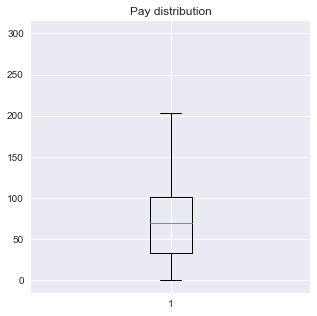

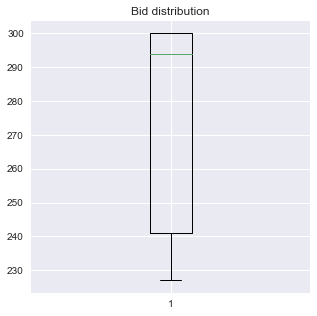

In [66]:
#pay distribution: median = 75
#The long upper whisker in the pay distribution means that bidders' views are varied amongst the most positive quartile group,
#and more similar for the least positive quartile group. 

plt.figure(13,figsize=(5,5))
plt.boxplot(train_df.payprice)
plt.title("Pay distribution")
plt.show()

# bid distribution: median = 294
# unevenly distributed, widely spread

plt.figure(14,figsize=(5,5))
plt.boxplot(train_df.bidprice)
plt.title("Bid distribution")
plt.show()

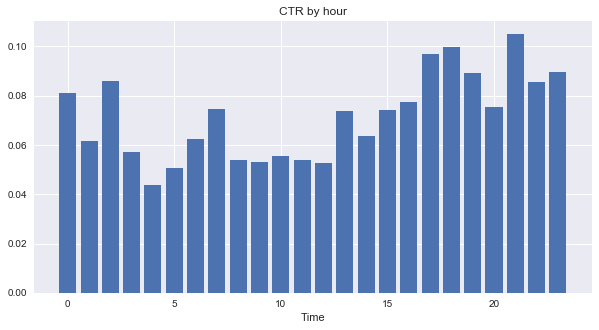

In [67]:
# Max CTR at 9PM at 0.11%
# Min CTR at 4AM at 0.04%
# From 2PM until 6PM upward trend 
# From 6PM until 8PM downward trend
# Spike at 9PM
# Downward trend from 9PM until 1AM 
# Spike at 2AM
# Downward trend from 2AM until 4AM
# Increase from 4AM until 7AM
# Between 8AM and 12PM, steady at 0.05% 

hours_CTR = (train_df[train_df.click==1].hour.value_counts().sort_index()/train_df[train_df.click==0].hour.value_counts().sort_index())*100

plt.figure(5,figsize=(10,5))
plt.bar(hours_CTR.index,hours_CTR,align="center")
plt.title("CTR by hour")
plt.xlabel("Time")
plt.show()

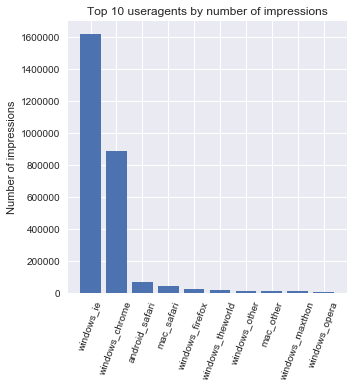

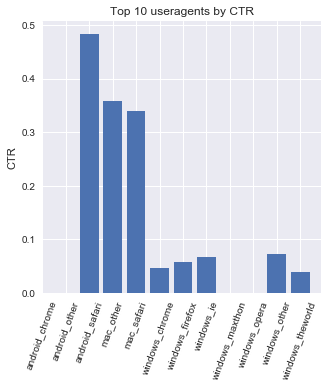

In [68]:
# Max number of impressions with Internet Explorer on Windows machine, however highest CTR on Android at 0.48%
# While Safari on Mac impression frequency is much lower than on Internet Explorer, CTR is significantly higher: 0.33% v 0.06%


top_ten_useragents_all=train_df.useragent.value_counts().sort_values(ascending=False)[0:10]
top_ten_useragents_ctr = (train_df[train_df.click==1].useragent.value_counts().sort_values(ascending=False)[0:10]/train_df[train_df.click==0].useragent.value_counts().sort_values(ascending=False)[0:10])*100

plt.figure(6,figsize=(5,5))
plt.bar(range(0,len(top_ten_useragents_all)),top_ten_useragents_all,tick_label=top_ten_useragents_all.index)
plt.xticks(rotation=70)
plt.title("Top 10 useragents by number of impressions")
plt.ylabel("Number of impressions")
plt.show()


plt.figure(8,figsize=(5,5))
plt.bar(range(0,len(top_ten_useragents_ctr)),top_ten_useragents_ctr,tick_label=top_ten_useragents_ctr.index)
plt.xticks(rotation=70)
plt.title("Top 10 useragents by CTR")
plt.ylabel("CTR")
plt.show()

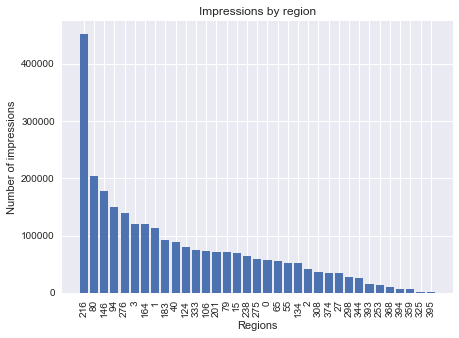

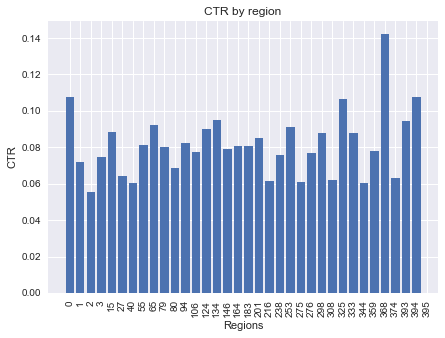

In [69]:
#region
top_ten_region_all=train_df.region.value_counts().sort_values(ascending=False)
top_ten_region_ctr=(train_df[train_df.click==1].region.value_counts().sort_values(ascending=False)/train_df[train_df.click==0].region.value_counts().sort_values(ascending=False))*100

plt.figure(9,figsize=(7,5))
plt.bar(range(0,len(top_ten_region_all)),top_ten_region_all,tick_label=top_ten_region_all.index)
plt.xticks(rotation=90)
plt.title("Impressions by region")
plt.xlabel("Regions")
plt.ylabel("Number of impressions")
plt.show()

plt.figure(10,figsize=(7,5))
plt.bar(range(0,len(top_ten_region_ctr)),top_ten_region_ctr,tick_label=top_ten_region_ctr.index)
plt.xticks(rotation=90)
plt.title("CTR by region")
plt.xlabel("Regions")
plt.ylabel("CTR")
plt.show()

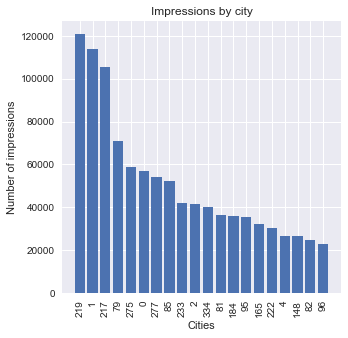

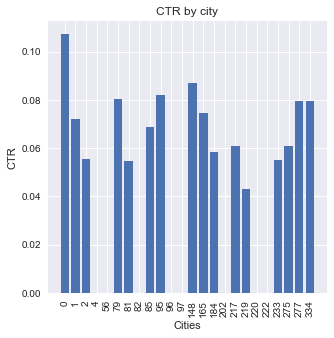

In [70]:
#city
top_ten_city_all=train_df.city.value_counts().sort_values(ascending=False)[0:20]
top_ten_city_ctr=(train_df[train_df.click==1].city.value_counts().sort_values(ascending=False)[0:20]/train_df[train_df.click==0].city.value_counts().sort_values(ascending=False)[0:20])*100

plt.figure(10,figsize=(5,5))
plt.bar(range(0,len(top_ten_city_all)),top_ten_city_all,tick_label=top_ten_city_all.index)
plt.xticks(rotation=90)
plt.title("Impressions by city")
plt.xlabel("Cities")
plt.ylabel("Number of impressions")
plt.show()

plt.figure(11,figsize=(5,5))
plt.bar(range(0,len(top_ten_city_ctr)),top_ten_city_ctr,tick_label=top_ten_city_ctr.index)
plt.xticks(rotation=90)
plt.title("CTR by city")
plt.xlabel("Cities")
plt.ylabel("CTR")
plt.show()

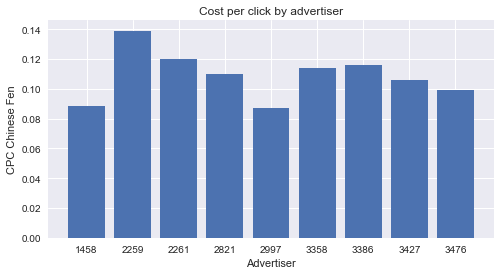

In [71]:
# Highest CPC => advertiser 2259, Lowest CPC => advertisers 1458 & 2997

cpc_per_advertiser = (pd.DataFrame(train_df.groupby(["advertiser"]).\
                                   apply(lambda x:x[(x.bidprice>x.payprice)&(x.click==1)].payprice.sum()/(x[(x.bidprice>x.payprice)].click.sum()))))/1000

plt.figure(8,figsize=(8,4))
plt.bar(range(1,len(cpc_per_advertiser)+1),cpc_per_advertiser.values,\
        tick_label=cpc_per_advertiser.index)
plt.xlabel("Advertiser")
plt.ylabel("CPC Chinese Fen")
plt.title("Cost per click by advertiser")
plt.show()

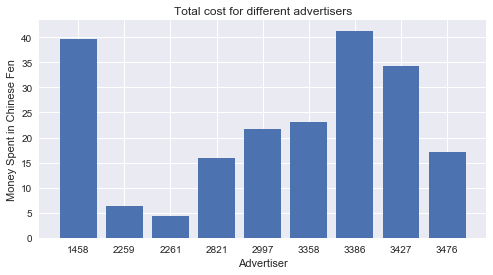

In [72]:
total_pay_per_advertiser = (pd.DataFrame(train_df.groupby(["advertiser"])\
                                        .apply(lambda x:x[(x.bidprice>x.payprice)&(x.click==1)].payprice.sum())))/1000

plt.figure(8,figsize=(8,4))
plt.bar(range(1,len(total_pay_per_advertiser)+1),total_pay_per_advertiser.values,\
        tick_label=total_pay_per_advertiser.index)
plt.xlabel("Advertiser")
plt.ylabel("Money Spent in Chinese Fen")
plt.title("Total cost for different advertisers")
plt.show()

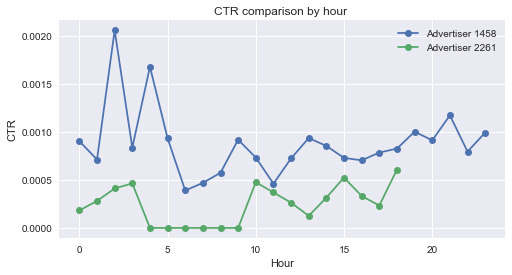

In [73]:
ctr_per_advertiser_and_hour = pd.DataFrame(train_df.groupby(["advertiser","hour"])\
                                              .apply(lambda x:x.click.sum()/len(x)))

plot_statistics(ctr_per_advertiser_and_hour,"Hour","CTR","CTR comparison by hour ",format_="-o")

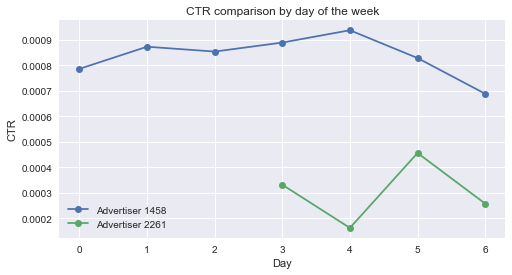

In [74]:
ctr_per_advertiser_and_weekday = pd.DataFrame(train_df.groupby(["advertiser","weekday"])\
                                              .apply(lambda x:x.click.sum()/len(x)))

plot_statistics(ctr_per_advertiser_and_weekday,"Day","CTR","CTR comparison by day of the week",format_="-o")

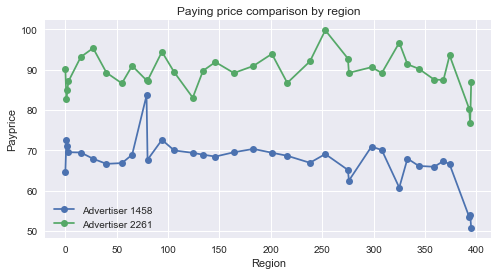

In [75]:
payprice_per_advertiser_and_region = pd.DataFrame(train_df.groupby(["advertiser","region"])\
                                              .apply(lambda x:x.payprice.mean()))

plot_statistics(payprice_per_advertiser_and_region,"Region","Payprice",\
                title="Paying price comparison by region",format_="-o")

### Pre-processing code

In [76]:
def merge_split_df(train_set=None,val_set=None,test_set=None,concat_set=None,action="merge",len_train=None,len_val=None,len_test=None):
    
    if action=="merge":
    
        concat_set=pd.DataFrame()
        concat_set=concat_set.append(train_set)
        concat_set=concat_set.append(val_set)
        concat_set=concat_set.append(test_set)
        
        concat_set.reset_index(inplace=True)
        concat_set.drop(["index"],axis=1,inplace=True)
        
        
        
        len_train = len(train_set)
        len_val = len(val_set)
        len_test = len(test_set)
        
        
        return concat_set,len_train,len_val,len_test
    
    if action=="split":
        
        train_set = concat_set[0:len_train]
        train_set.reset_index(inplace=True)
        train_set = train_set.drop("index",axis=1)
        #concat_df.drop(list(range(0,len_train)),inplace=True)
        
        val_set = concat_set[len_train:len_train+len_val]
        val_set.reset_index(inplace=True)
        val_set = val_set.drop("index",axis=1)
        #concat_df.drop(list(range(len_train,len_train+len_val)),inplace=True)
        
        test_set = concat_set[len_train+len_val:len_train+len_val+len_test]
        test_set.reset_index(inplace=True)
        test_set = test_set.drop("index",axis=1)
        #concat_df.drop(list(range(len_train+len_val,len_train+len_val+len_test)),inplace=True)
        return train_set, val_set, test_set

In [77]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [78]:
#columns_to_hot_encode=["weekday","useragent","region","city","adexchange","slotvisibility","slotformat","creative","keypage","advertiser"]
def hot_encode_columns(df, list_of_columns_to_hot_encode):
    for col in list_of_columns_to_hot_encode:
        df[col] = df[col].astype('object')
    
    one_hot=pd.get_dummies(df[list_of_columns_to_hot_encode])
    
    df=df.join(one_hot)
    #df.drop(list_of_columns_to_hot_encode,axis=1,inplace=True)
    return df

In [79]:
#One hot encode useragent
def one_hot_encode_useragent(df):
    df.useragent=df.useragent.str.replace("_"," ")
    vect = CountVectorizer()
    X = vect.fit_transform(df.useragent)
    df=df.join(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))
    #df.drop("usertag",axis=1,inplace=True)
    return df, vect.get_feature_names()

In [80]:
def click_prediction_to_df(df,used_model,threshold_to_predict_click=0.5):
    
    df["prob_of_click"] = pd.DataFrame(used_model.predict_proba(df[features]))[1]
    df["predicted_click"] = df.prob_of_click.apply(lambda x: 1 if x > threshold_to_predict_click else 0)
    #df["pctr"]=df.prob_of_click/df.prob_of_click.mean()

In [81]:
#One hot encode tags
def one_hot_encode_tags(df):
    df.usertag=df.usertag.str.replace(","," ")
    vect = CountVectorizer()
    X = vect.fit_transform(df.usertag)
    df=df.join(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))
    #df.drop("usertag",axis=1,inplace=True)
    return df, vect.get_feature_names()

In [82]:
#remove unwanted features
def remove_features(df,feature_list):
    df.drop(feature_list,axis=1,inplace=True)
    df.reset_index(inplace=True,drop="Index")

In [83]:
#checks for duplicates, weekday range, hour range
def check(df, duplicates=True,weekday=True,hour=True,pay_bidding_price=True):
    
    if duplicates==True:
        if len(df)==len(df.drop_duplicates()):
            print("there are no duplicates")
        else:
            df.drop_duplicates(inplace=True)
            print("duplicates removed")
            
    if weekday==True:
        assert(df.weekday.max()<=6)
        assert(df.weekday.min()>=0)
        
    if hour==True:
        assert(df.weekday.max()<=23)
        assert(df.weekday.min()>=0)
        
    if pay_bidding_price==True:
        
        num_rows_to_drop=len(df[df.payprice>df.bidprice])
        if num_rows_to_drop>0:
            df.drop(df[df.payprice>df.bidprice].index,inplace=True)
            print(num_rows_to_drop,"rows dropped to fix pay_bid_price")

In [84]:
def assertions(df):
    assert(len(df)==len(df.bidid.unique()))
    assert(df.logtype.unique()==1)
    assert(df.urlid.unique()=="null")

In [85]:
def ctr_priors(df,features,usertags,useragents):
    
    len_of_df=len(df)
    
    if "usertag" in features:
        features=features+usertags
        features=[x for x in features if x not in ["usertag"]]
    
    if "useragent" in features:
        features=features+useragents
        features=[x for x in features if x not in ["useragent"]]
    
    for feature in features:            
        
        for value_of_feature in df[feature].unique():
            ctr_of_value_of_feature=len(df[(df[feature]==value_of_feature)&(df.click==1)])/len_of_df
            df.ix[df[feature]==value_of_feature,"ctr_"+feature]=ctr_of_value_of_feature

In [86]:
def preprocess(df,features_to_remove=None,find_prior_for=None,lst_of_features_to_onehot=None,\
do_onehot_useragents=True,do_onehot_usertags=True):
    
    
    assertions(df)
    
    if features_to_remove != None:
        remove_features(df,features_to_remove)
    
    if do_onehot_useragents:
        df,user_agents = one_hot_encode_useragent(df)
    
    if do_onehot_usertags:
        df,user_tags = one_hot_encode_tags(df)

    if find_prior_for != None:
        ctr_priors(df,features=find_prior_for,useragents=user_agents,usertags=user_tags)

    if lst_of_features_to_onehot != None:
        df=hot_encode_columns(df,lst_of_features_to_onehot)
    
    return df

In [87]:
def downsample(df,n=2034,seed=25):
    np.random.seed(seed)
    concat_set=pd.DataFrame()
    
    
    sub_sample=df[df.click==0].sample(n)
    
    
    concat_set=concat_set.append(sub_sample)
    concat_set=concat_set.append(df[df.click==1])
    concat_set.sample(frac=1)
    
    return concat_set

### Preprocessing implementation

In [88]:
#check train_df, val_df and test_df for inconsistencies
check(train_df,duplicates=True,weekday=True,hour=True,pay_bidding_price=True)
check(val_df,duplicates=True,weekday=True,hour=True,pay_bidding_price=True)
check(test_df,duplicates=True,weekday=True,hour=True,pay_bidding_price=False)

there are no duplicates
33579 rows dropped to fix pay_bid_price
there are no duplicates
3691 rows dropped to fix pay_bid_price
there are no duplicates


In [89]:
#train_df_downsampled = downsample(train_df, n=8000, seed=25)
train_df_downsampled = train_df

In [90]:
#concat datasets
concat_df,len_downsampled_train,len_val,len_test = merge_split_df(train_set=train_df_downsampled, \
                                                                  val_set=val_df, test_set=test_df,action="merge")

%xdel train_df_downsampled
%xdel val_df
%xdel test_df

In [91]:
#preprocess
features_to_remove = ["logtype","IP","urlid","userid","domain","url","slotid"]
lst_of_features_to_onehot = ["weekday","region","city","adexchange","slotvisibility","slotformat","creative","advertiser","keypage"]
find_prior_for = ["weekday","hour","city","slotwidth","slotheight","slotvisibility","slotformat","creative"]


concat_df = preprocess(concat_df,\
                       features_to_remove=features_to_remove,\
                       find_prior_for=None, \
                       lst_of_features_to_onehot=lst_of_features_to_onehot,\
                       do_onehot_useragents=True,\
                       do_onehot_usertags=True)

In [92]:
#split datasets
train_df_, val_df, test_df = merge_split_df(concat_set=concat_df,\
                                            action="split",\
                                            len_train=len_downsampled_train,\
                                            len_val=len_val,len_test=len_test)
%xdel concat_df

In [93]:
#downsample for training
train_df_downsampled = downsample(train_df_, n=8000, seed=25)

## Models for predicting likelihood for clicks

In [94]:
features = [x for x in train_df_downsampled.columns if x not in \
           ["bidid","weekday","region","city","adexchange","slotvisibility","slotformat",\
            "creative","keypage","advertiser","bidprice","payprice","click","useragent","usertag"]]

In [95]:
X_train = train_df_downsampled[features]
Y_train = train_df_downsampled["click"]

X_dev = val_df[features]
Y_dev = val_df["click"]

###  Logistic regression

In [96]:
# ===========Find best logistic regression model=============
c_range = np.arange(0.32,0.34,0.001) #for roc_auc
#c_range = np.linspace(start=0.0001,stop=2,num=50)
c_range = [0.32]
#c_range=np.arange(0.01,0.03,0.001) #for precision

tuned_parameters = [{'C': c_range,"solver":["liblinear"],"penalty":["l1"],
                     "class_weight":["balanced"]}]

scores=["roc_auc"]#["neg_mean_squared_error"]#["roc_auc"]
for score in scores:
    lr_model=GridSearchCV(LogisticRegression(),param_grid=tuned_parameters,scoring=score,cv=3,n_jobs=-1)
    lr_model.fit(X_train, Y_train)

    #print("Scoring: ",score)
    print("parameters selected: ",lr_model.best_params_)
    print(" ")
    print("Train set:")
    print(score+":",lr_model.best_score_)
    print(" ")
#------------------------------------------------------------

parameters selected:  {'C': 0.32, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
 
Train set:
roc_auc: 0.831598847707
 


In [97]:
#====================Fit the model found=====================
lr=LogisticRegression(C=lr_model.best_params_["C"],class_weight=lr_model.best_params_["class_weight"]\
                         ,penalty=lr_model.best_params_["penalty"],solver=lr_model.best_params_["solver"],n_jobs=-1)
lr.fit(X_train,Y_train)    
#------------------------------------------------------------

LogisticRegression(C=0.32, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [98]:
#===================Performance of the model=================
preds=lr.predict(X_dev)
print("Test set:")
print("roc_auc:",roc_auc_score(y_score=preds, y_true=Y_dev))
print("recall:",recall_score(y_pred=preds, y_true=Y_dev))
print("precision:",precision_score(y_pred=preds,y_true=Y_dev))
print("rmse: ",mean_squared_error(y_pred=preds,y_true=Y_dev))
print(" ")
print("# of all impressions: {}".format(len(X_dev)))
print("true # of clicks:",sum(Y_dev),"|| # of clicks correctly predicted:",\
      sum(lr.predict(X_dev.ix[Y_dev[Y_dev==1].index,:])),"|| total # of clicks predicted:",sum(preds))
#------------------------------------------------------------

Test set:
roc_auc: 0.760350320722
recall: 0.709090909091
precision: 0.00279124693589
rmse:  0.188466449142
 
# of all impressions: 296058
true # of clicks: 220.0 || # of clicks correctly predicted: 156.0 || total # of clicks predicted: 55889.0


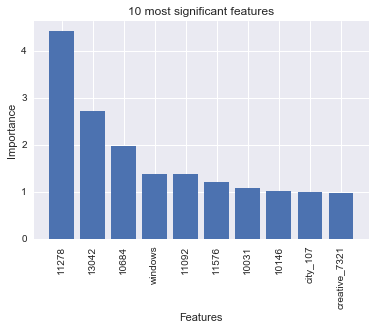

In [99]:
importances=pd.Series(abs(lr.coef_[0]),index=X_train[features].columns)
importances.sort_values(inplace=True,ascending=False)


plt.bar(range(0,len(importances[0:10])),importances[0:10],\
        tick_label=importances.index[0:10])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("10 most significant features")

plt.show()

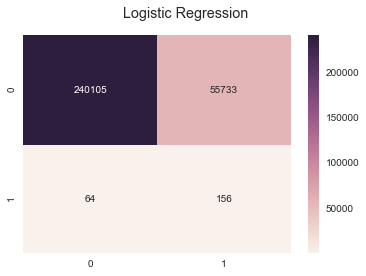

In [100]:
sns.heatmap(confusion_matrix(Y_dev, preds, labels=[0,1]),annot=True,fmt="d")
sns.set(font_scale=1)
sns.plt.suptitle('Logistic Regression')

## Best independent bidding strategy

In [101]:
def plot_bidding_metrics(df,label_="train_set",plotting_column="constant_bid"):
    plt.figure(0,figsize=(10,10))

    df = df.copy()
    df = df.sort_values(plotting_column)
    
    plt.subplot(2,2,1)
    plt.plot(df[plotting_column],df["num_clicks"],"o",label=label_)
    plt.xlabel(plotting_column)
    plt.ylabel("Num of Clicks Succeeded")
    plt.title("Num of Clicks Succeeded - "+plotting_column)
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(df[plotting_column],df["ctr"],"o",label=label_)
    plt.xlabel(plotting_column)
    plt.ylabel("CTR")
    plt.title("CTR - "+plotting_column)
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(df[plotting_column],df["cpc"],"o",label=label_)
    plt.xlabel(plotting_column)
    plt.ylabel("CPC")
    plt.title("CPC - "+plotting_column)
    plt.legend()

    plt.show()
    
    print("Best result:")
    print("======================================================================================================")
    print(df.sort_values(["num_clicks","ctr","budget_spent"],ascending=False).head(1))
    print("======================================================================================================")

In [102]:
def metrics_for_bidding_old(df,budget,type_of_bidding,constant_bid=None,a_coef=None,b_coef=None,bias=None,bid_for_all=None):
    
    if type_of_bidding == "constant":
        if constant_bid == None:
            return "Provide a constant bid"
        else:
            df["bid_constant"] = constant_bid
            impressions_that_can_be_won = df[df.bid_constant>df.payprice].copy()
    
    elif type_of_bidding == "linear":
        if a_coef == None or bias == None or bid_for_all == None or b_coef == None:
            return "Provide a_coef, b_coef, bias and bid_for_all"
        
        else:
            avg_ctr = 1
            #MODEL
            df["temporary_bid"] = (b_coef)*np.power(df["prob_of_click"],2) + (a_coef/avg_ctr)*df["prob_of_click"] + bias
            impressions_that_can_be_won = df[df.temporary_bid>df.payprice].copy()        

    if bid_for_all == False:        
        certain_zeros = impressions_that_can_be_won[(impressions_that_can_be_won.prob_of_click<0.04)].index
        impressions_that_can_be_won.drop(certain_zeros,inplace=True)

            
            
    impressions_that_can_be_won["budget_spent"]=impressions_that_can_be_won.payprice.cumsum()
    impressions_won = impressions_that_can_be_won[impressions_that_can_be_won.budget_spent<=budget]
    budget_spent = np.array(impressions_won.budget_spent[-1:])
    num_clicks = impressions_won.click.sum()
    num_impressions_won = len(impressions_won)
    ctr = num_clicks/num_impressions_won
    cpc = (budget_spent/num_clicks)[0]

    return ctr,num_clicks, cpc, budget_spent[0], num_impressions_won

In [103]:
def metrics_for_polynomial_bidding(df,budget,a_coef,b_coef,bias,bid_for_all):
    

    df["temporary_bid"] = (b_coef)*np.power(df["prob_of_click"],2) + (a_coef)*df["prob_of_click"] + bias
    impressions_that_can_be_won = df[df.temporary_bid>df.payprice].copy()        

    if bid_for_all == False:        
        certain_zeros = impressions_that_can_be_won[(impressions_that_can_be_won.prob_of_click<0.04)].index
        impressions_that_can_be_won.drop(certain_zeros,inplace=True)

    impressions_that_can_be_won["budget_spent"]=impressions_that_can_be_won.payprice.cumsum()
    impressions_won = impressions_that_can_be_won[impressions_that_can_be_won.budget_spent<=budget]
    budget_spent = np.array(impressions_won.budget_spent[-1:])
    num_clicks = impressions_won.click.sum()
    num_impressions_won = len(impressions_won)
    ctr = num_clicks/num_impressions_won
    #cpc = (num_clicks/budget_spent)[0]
    cpc = (budget_spent/(num_clicks)/1000)[0]

    return ctr,num_clicks, cpc, budget_spent[0], num_impressions_won

In [104]:
def apply_bids_to_df(df,b_coef,a_coef,bias,bidded_for_all,column_name):
    df[column_name] = (b_coef)*np.power(df["prob_of_click"],2) + (a_coef)*df["prob_of_click"] + bias
    
    
    if bidded_for_all == False:
        certain_zeros = df[(df.prob_of_click<0.04)].index
        df.ix[certain_zeros,column_name] = 0

### Tuning the bidding strategy

In [105]:
ctr_per_advertiser_and_hour = pd.DataFrame(train_df.groupby(["advertiser","hour"])\
                                              .apply(lambda x:x.click.sum()/len(x)))

def tune_polynomial_bidding(df,budget,csv_name,tune_b_coef,tune_a_coef,tune_bias,bid_for_all,\
                            load,nfolds=3,examples_in_fold = len(val_df)):
    
    if load == False:
        range_b_coef = [160]#np.linspace(start=100,stop=500,num=41) 
        range_a_coef = np.linspace(start=610,stop=640,num=31)#np.linspace(start=610,stop=630,num=21)
        range_bias = np.linspace(start=-10,stop=10,num=31)#np.linspace(start=120,stop=160,num=81) 
        
        
        if tune_b_coef == False:
            range_b_coef = [0]
            
        if tune_a_coef == False:
            range_a_coef = [0]
            
        if tune_bias == False:
            range_bias = [0]            

        total_rounds = range(len(range_b_coef)*len(range_a_coef)*len(range_bias)*nfolds)
        results_df = pd.DataFrame(index=total_rounds)
                
        index = -1
        rounds = 0
        print("Total rounds: {}".format(len(total_rounds)/nfolds))
        for b_coef in range_b_coef:
            for a_coef in range_a_coef:
                for bias in range_bias:
                    
                    rounds +=1
                    print("Round {}, b_coef: {}, a_coef: {}, bias: {}".format(rounds,b_coef,a_coef,bias))
                    
                    for i in range(0,nfolds):    
                        index += 1
                        ctr,num_clicks,cpc,budget_spent,num_impressions = \
                                        metrics_for_polynomial_bidding(df.sample(n=examples_in_fold),\
                                                                       budget,\
                                                                       b_coef=b_coef,\
                                                                       a_coef=a_coef,\
                                                                       bias=bias,\
                                                                       bid_for_all=bid_for_all)
                    

                        results_df.ix[index,"ctr"] = ctr
                        results_df.ix[index,"num_clicks"] = num_clicks
                        results_df.ix[index,"cpc"] = cpc
                        results_df.ix[index,"budget_spent"] = budget_spent
                        results_df.ix[index,"hour"] = hour
                        results_df.ix[index,"ctr_per_advertiser_and_hour"] = ctr_per_advertiser_and_hour
                        results_df.ix[index,"b_coef"] = b_coef
                        results_df.ix[index,"a_coef"] = a_coef
                        results_df.ix[index,"bias"] = bias



        aggregated_results_df = results_df.groupby(["b_coef","a_coef","bias"]).mean()\
                            [["num_clicks","ctr","budget_spent","cpc"]]\
                            .sort_values(["num_clicks","ctr","budget_spent"],ascending=False).reset_index()              

        results_df.sort_values(["num_clicks","ctr","budget_spent"],ascending=False,inplace=True)
        results_df.reset_index(inplace=True,drop="index")
        results_df.to_csv(csv_name)

        print("Best Result:")
        print(aggregated_results_df.ix[0,:])


        return aggregated_results_df, results_df    
        
    else:
        results_df = pd.read_csv(csv_name,index_col=0)
        
        aggregated_results_df = results_df.groupby(["b_coef","a_coef","bias"]).mean()\
                                [["num_clicks","ctr","budget_spent","cpc"]]\
                                .sort_values(["num_clicks","ctr","budget_spent"],ascending=False).reset_index()         

        print("Best Result:")
        print(aggregated_results_df.ix[0,:])
        return aggregated_results_df, results_df

NameError: name 'train_df' is not defined